# [DeepSphere]: a spherical convolutional neural network
[DeepSphere]: https://github.com/SwissDataScienceCenter/DeepSphere

[Nathanaël Perraudin](https://perraudin.info), [Michaël Defferrard](http://deff.ch), Tomasz Kacprzak, Raphael Sgier

# Figures for the paper

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import numpy as np
from scipy.interpolate import interp1d
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import healpy as hp
import pygsp
import svgutils.compose as sc
import IPython.display as ipd

import hyperparameters
from deepsphere import utils, plot, models
import experimental.cnn

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""

plt.rcParams['figure.figsize'] = (17, 5)  # (9, 4) for matplotlib notebook
matplotlib.rcParams.update({'font.size': 10})

In [4]:
pathfig = './figures/'
os.makedirs(pathfig, exist_ok=True)

## 1 Graph

### 1.1 Full sphere

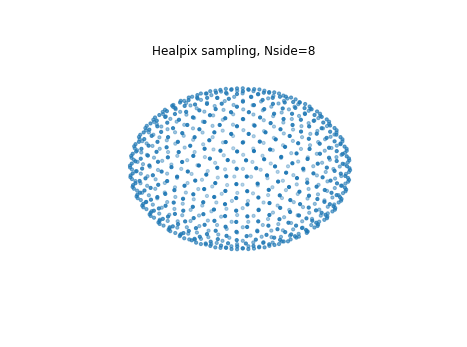

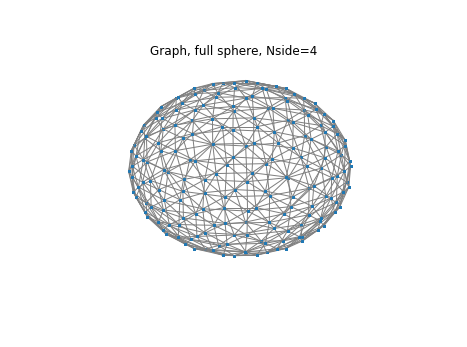

In [5]:
fig = plt.figure(figsize=[8,6])

ax = fig.add_subplot(111, projection='3d')
G = utils.healpix_graph(nside=8, nest=True)
G.plotting.update(vertex_size=10)
G.plot(ax=ax,edges=False)

# Get rid of the ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# Get rid of the panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.set_title('Healpix sampling, Nside=8')
plt.savefig(os.path.join(pathfig, "healpix_sampling_8.pdf"), bbox_inches='tight')

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111, projection='3d')
G = utils.healpix_graph(nside=4, nest=True)
G.plotting.update(vertex_size=20)
G.plot(ax=ax)

# Get rid of the ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# Get rid of the panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.set_title('Graph, full sphere, Nside=4')
plt.savefig(os.path.join(pathfig, "healpix_graph_4.pdf"), bbox_inches='tight')

### 1.2 Half the sphere

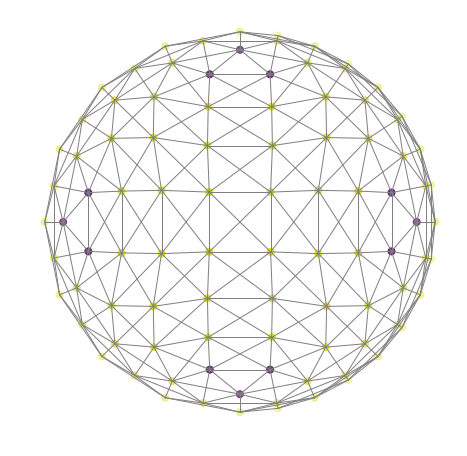

In [6]:
nside = 4
npoints = hp.nside2npix(nside)
indexes = hp.reorder(np.array(list(range(npoints))),n2r=True)[:npoints//2]

G = utils.healpix_graph(nside=nside, nest=True, indexes=indexes)
G.plotting['elevation']=90
G.plotting['azimuth']=0
G.plotting.update(vertex_size=50)

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111, projection='3d')
# plt.cm.Blues_r

# Highlight the node with a degree of 7 on the full sphere
G2 = utils.healpix_graph(nside=nside, nest=True)
snode = np.arange(0,G2.N)[G2.d==7]
sindex = set(indexes)
snode2 = [el for el in snode if el in sindex]
hl_index = [np.argmin(np.abs(indexes-el)) for el in snode2]
sig = np.zeros([G.N])
sig[hl_index]=1

G.plot_signal(1-sig, ax=ax,colorbar=False)
# G.plot(ax=ax)
# Get rid of the ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# Get rid of the panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Remove the title
# ax.set_title('Graph, half sphere, Nside=4')
ax.set_title('')

# Zoom in
c = 0.6
plt.axis([c*min(G.coords[:,0]), c*max(G.coords[:,0]), c*min(G.coords[:,1]), c*max(G.coords[:,1]) ])

fig.savefig(os.path.join(pathfig, "half_graph_{}.pdf").format(nside), bbox_inches='tight')

## 2 Pooling

A better figure is made in the `figure_pooling` notebook.

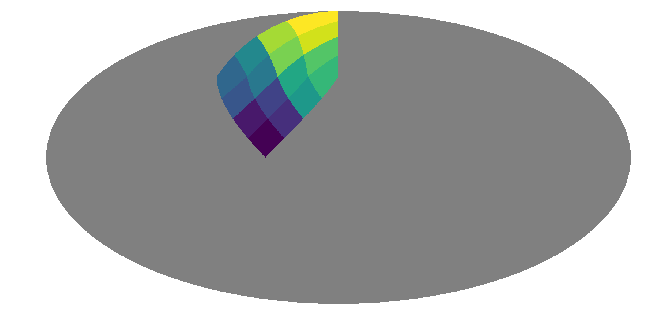

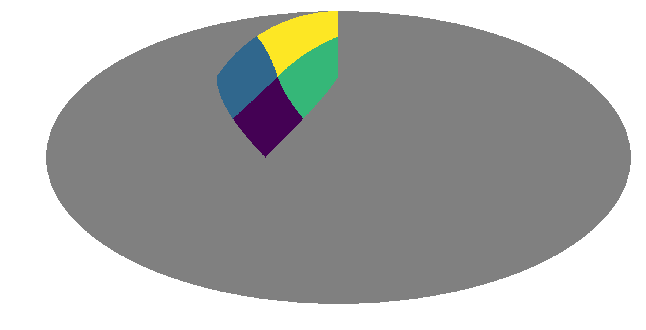

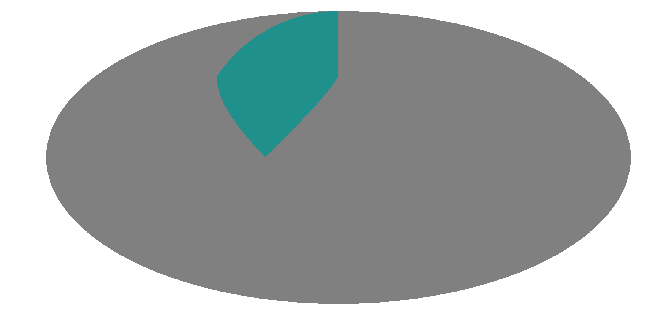

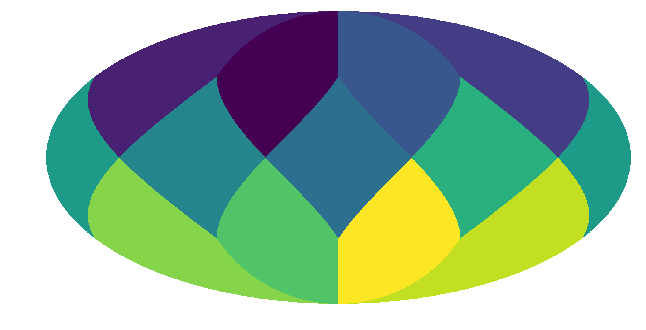

In [7]:
order = 4

index = np.arange(hp.nside2npix(order)) + 1
mask = np.zeros_like(index, dtype=np.bool)
mask[:order**2] = 1
index *= mask
index = index.astype(np.float)
index[index==0] = hp.UNSEEN
hp.mollview(index, title='', nest=True, cbar=False,cmap=None, xsize=1600)
plt.savefig(os.path.join(pathfig, "pooling-order4.pdf"), bbox_inches='tight')

order = 2
index = np.arange(hp.nside2npix(order)) + 1
mask = np.zeros_like(index, dtype=np.bool)
mask[:order**2] = 1
index *= mask
index = index.astype(np.float)
index[index==0] = hp.UNSEEN
hp.mollview(index, title='', nest=True, cbar=False,cmap=None, xsize=1600)
plt.savefig(os.path.join(pathfig, "pooling-order2.pdf"), bbox_inches='tight')

order = 1
index = np.arange(hp.nside2npix(order)) + 1
mask = np.zeros_like(index, dtype=np.bool)
mask[:order**2] = 1
index *= mask
index = index.astype(np.float)
index[index==0] = hp.UNSEEN
hp.mollview(index, title='', nest=True, cbar=False,cmap=None, xsize=1600)
plt.savefig(os.path.join(pathfig, "pooling-order1.pdf"), bbox_inches='tight')

index = np.array(list(range(12)))
hp.mollview(index, title='', nest=True, cbar=False,cmap=None, xsize=1600)
plt.savefig(os.path.join(pathfig, "12parts.pdf"), bbox_inches='tight')

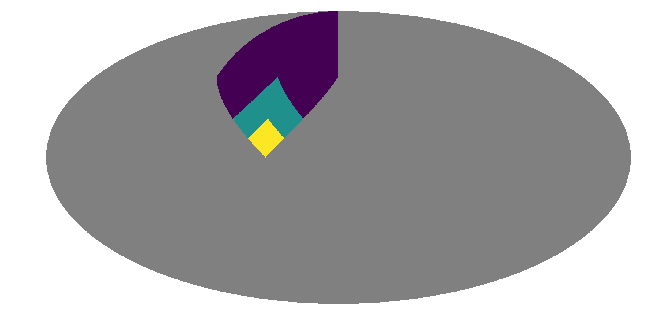

In [8]:
orders = [1,2,4]
order_max = max(orders)
npix = hp.nside2npix(order_max)
index = np.zeros([npix])
for order in orders:
    index[:order**2] = index[:order**2]+1
index.astype(np.float)
index[index==0] = hp.UNSEEN
hp.mollview(index, title='', nest=True, cbar=False,cmap=None, xsize=1600)
plt.savefig(os.path.join(pathfig, "part_sphere.pdf"), bbox_inches='tight')

/home/defferra/miniconda3/envs/scnn/lib/python3.6/site-packages/healpy/projector.py:750: RuntimeWarning: invalid value encountered in greater
  mask = (np.asarray(x)**2+np.asarray(y)**2>1.0)
/home/defferra/miniconda3/envs/scnn/lib/python3.6/site-packages/healpy/projaxes.py:387: RuntimeWarning: invalid value encountered in greater
  w=np.where(d2 > threshold)[0]


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 360 deg 0.00'.
The interval between meridians is 360 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 360 deg 0.00'.
The interval between meridians is 360 deg 0.00'.


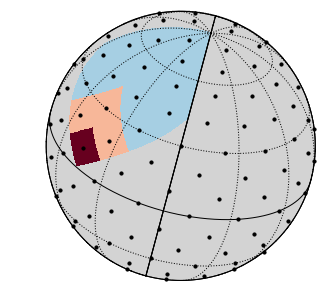

In [9]:
def make_ball(map_test1, cmap=plt.cm.gray_r, sub=None, vmin =-0.5, vmax=1.5):
    cmap.set_under('w')
    cmap.set_bad('lightgray')
    dot_size=10
    rot = (0,30,345)
    hp.visufunc.orthview(map=map_test1, half_sky=True, title='', rot=rot, cmap=cmap, cbar=False, hold=True, nest=True, min=vmin, max=vmax, notext=True, sub=sub);
    theta, phi = hp.pix2ang(hp.npix2nside(len(map_test1)), range(len(map_test1)), nest=True);
    hp.projscatter(theta, phi, c='k', s=dot_size);
    hp.graticule();
    hp.graticule(dmer=360,dpar=360,alpha=1, rot=(0,0,15), local=True);
    hp.graticule(dmer=360,dpar=360,alpha=1, rot=(0,0,195), local=True);

orders = [1,2,4]
order_max = max(orders)
npix = hp.nside2npix(order_max)
index = np.zeros([npix])
for order in orders:
    index[:order**2] = index[:order**2]+1
index.astype(np.float)
index[index==0] = hp.UNSEEN
make_ball(index, cmap=plt.cm.RdBu_r, vmin=0, vmax=np.max(index))
plt.savefig(os.path.join(pathfig, "part_sphere2.pdf"), bbox_inches='tight')

## 3 Fourier basis

Let us display a few Fourier modes on the healpix map.

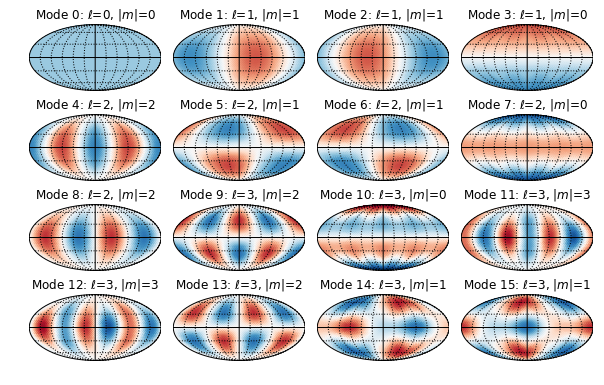

In [10]:
n_eigenvectors = 16

G = utils.healpix_graph(nside=16, lap_type='normalized', nest=True, dtype=np.float64)
G.compute_fourier_basis(n_eigenvectors=n_eigenvectors)

fig = plt.figure(figsize=(8, 5))
cm = plt.cm.RdBu_r
cm.set_under('w')

l, m = 0, 0
lm = []
for idx in range(n_eigenvectors):
    lm.append([l,m])
    m += 1
    if m > l:
        l += 1
        m = -l
ind = np.array([ 0,  1,  3,  2,  4,  5,  7, 6,  8, 10, 12, 9,  15, 14, 11, 13])

for idx in range(n_eigenvectors):
    l,m = lm[ind[idx]]
    hp.mollview(G.U[:, idx], 
                title='Mode {}: $\ell$={}, $|m|$={}'.format(idx, l, np.abs(m)),
                nest=True, 
                sub=(np.sqrt(n_eigenvectors), np.sqrt(n_eigenvectors), idx+1),
                max=np.max(np.abs(G.U[:, :n_eigenvectors])),
                min=-np.max(np.abs(G.U[:, :n_eigenvectors])),
                cbar=False,
                cmap=cm)

hp.graticule(verbose=False)
plt.savefig(os.path.join(pathfig, "eigenvectors.pdf"), bbox_inches='tight')

## 4 Convolution on graphs: show filters in spectral and spatial domains

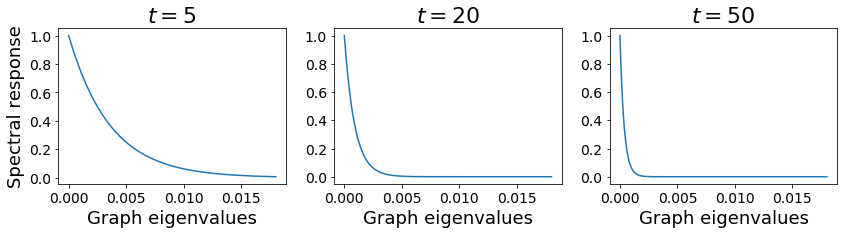

In [11]:
# taus = [5, 10, 20, 50]
taus = [5, 20, 50]
matplotlib.rcParams.update({'font.size': 14})
# fig, ax = plt.subplots(1,len(taus), figsize=(17, 4))
fig, ax = plt.subplots(1,len(taus), figsize=(12, 4))
for i,tau in enumerate(taus):
    hf = pygsp.filters.Heat(G, tau=tau)
    hf.plot(eigenvalues=False, sum=False, ax=ax[i])
    ax[i].set_xlabel('Graph eigenvalues', fontsize=18)
    if i is not 0:
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('Spectral response', fontsize=18)
    ax[i].set_title('$t={}$'.format(tau), fontsize=22)
fig.tight_layout(rect=[0, 0.05, 1, 0.92])

# plt.suptitle('Filter response in the graph spectral domain', fontsize=24)
plt.savefig(os.path.join(pathfig, "gaussian_filters_spectral.pdf"), bbox_inches='tight')
matplotlib.rcParams.update({'font.size': 10})

[1.4633307541073878e+59, 1.157301382871361e+59, 8.895350129450513e+66]


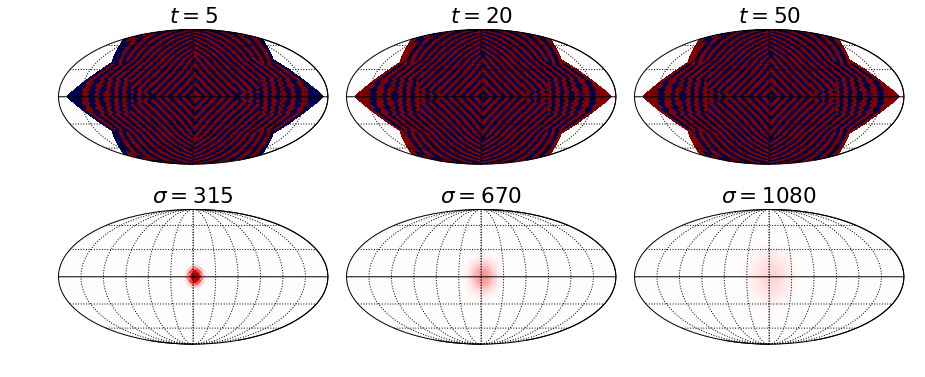

In [12]:
hf = pygsp.filters.Heat(G,tau=taus)

def arcmin2rad(x):
    return x / 60 / 360 * 2 * np.pi

def gaussian_smoothing(sig, sigma, nest=True):
    if nest:
        sig = hp.reorder(sig, n2r=True)
    smooth = hp.sphtfunc.smoothing(sig, sigma=arcmin2rad(sigma))
    if nest:
        smooth = hp.reorder(smooth, r2n=True)
    return smooth
_, center = plot.get_index_equator(hp.npix2nside(G.N), radius=20)
ind0 = center
sig = np.zeros(G.N)
sig[ind0] = 1
conv = hf.analyze(sig)

fig = plt.figure(figsize=(12, 5))
rel_diff = []
matplotlib.rcParams.update({'font.size': 18})
cm = plt.cm.seismic
# cm = plt.cm.jet
cm.set_under('w')
m = 0
#[315, 465, 670, 1080]
for i, (tau, sigma) in enumerate(zip(taus, [315, 670, 1080])):
    with utils.HiddenPrints():
        smooth = gaussian_smoothing(sig, sigma, nest=True)
    m = max(m, max(smooth))
    hp.mollview(conv[:, i], 
                title='$t={}$'.format(tau), 
                nest=True, 
                min=-m, max=m,
                cbar=False,
                rot=(180,0,180),
                sub=(2, len(taus), i+1),
                cmap=cm)
    
    hp.mollview(smooth, 
                title='$\sigma={}$'.format(sigma), 
                nest=True, 
                min=-m, max=m,
                cbar=False,
                rot=(180,0,180),
                sub=(2,len(taus),i+len(taus)+1),
                cmap=cm)
    
    diff = (conv[:, i]-smooth)
    rel_diff.append(np.linalg.norm(diff)/np.linalg.norm(smooth))
#     hp.mollview(diff, 
#                 title='', 
#                 nest=True,
#                 cbar=False,
#                 sub=(3, len(taus), i+2*len(taus)+1))
with utils.HiddenPrints():
    hp.graticule();

print(rel_diff)

plt.savefig(os.path.join(pathfig, "gaussian_filters_sphere.pdf"), bbox_inches='tight')

matplotlib.rcParams.update({'font.size': 10})

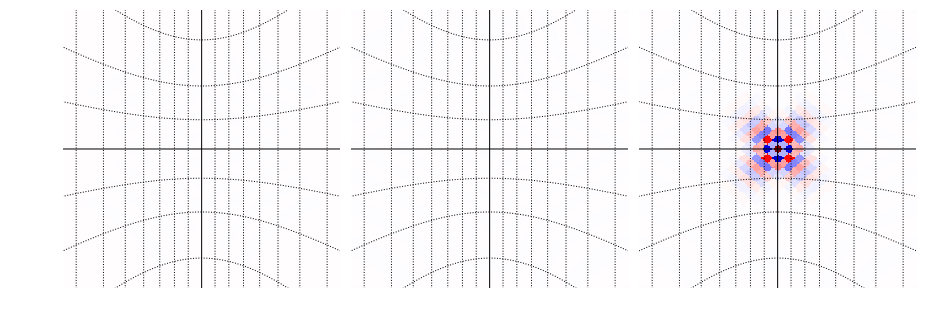

In [13]:
hf = pygsp.filters.Heat(G,tau=taus)
order = 20
matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure( figsize=(12, 5.5))
plot.plot_filters_gnomonic(filters=hf,order=order, title='', graticule=True)

# plt.suptitle('Gnomonic projection of a convoluted delta', fontsize=27)

plt.savefig(os.path.join(pathfig, "gaussian_filters_gnomonic.pdf"), bbox_inches='tight')
matplotlib.rcParams.update({'font.size': 10})

3 1


<Figure size 864x288 with 0 Axes>

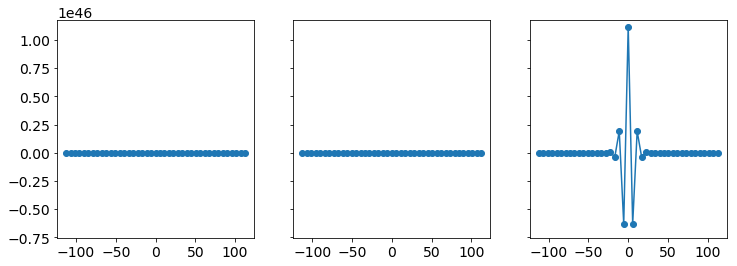

In [14]:
matplotlib.rcParams.update({'font.size': 14})
fig = plt.figure( figsize=(12, 4))
plot.plot_filters_section(hf, order=order, xlabel='', ylabel='', title='', marker='o')
# plt.suptitle('Section of a convoluted delta', fontsize=22)
plt.savefig(os.path.join(pathfig, "gaussian_filters_section.pdf"), bbox_inches='tight')
matplotlib.rcParams.update({'font.size': 10})

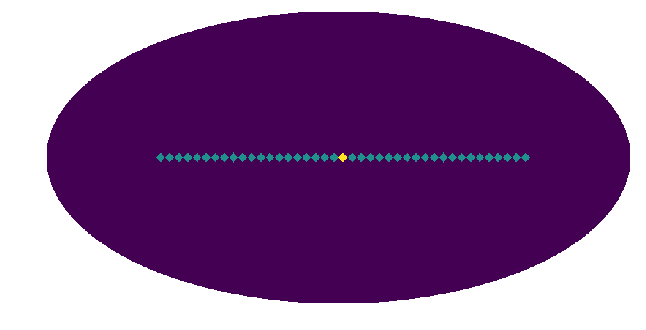

In [15]:
plot.plot_index_filters_section(hf,order=order)
plt.savefig(os.path.join(pathfig, "index_plotting_order{}_nside16.pdf".format(order)), bbox_inches='tight')

## 5 Experimental results: classification of convergence maps in two model classes

In [16]:
sigma=3
deepsphere_result_fcn = np.load('results/deepsphere/deepsphere_results_list_sigma{}_FCN.npz'.format(sigma))['data'][-15:]
deepsphere_result_cnn = np.load('results/deepsphere/deepsphere_results_list_sigma{}_CNN.npz'.format(sigma))['data'][-15:]
hist_result = np.load('results/histogram/histogram_results_list_sigma{}.npz'.format(sigma))['data'][-15:]
psd_result = np.load('results/psd/psd_results_list_sigma{}.npz'.format(sigma))['data']

cnn2d_result_fcn_reg = np.load('results/2dcnn/reg3_deepsphere_results_list_sigma{}_FCN-2d.npz'.format(sigma))['data'][:15]
cnn2d_result_cnn_reg = np.load('results/2dcnn/reg3_deepsphere_results_list_sigma{}_CNN-2d.npz'.format(sigma))['data'][:15]
cnn2d_result_fcn_big_reg = np.load('results/2dcnn/reg3_deepsphere_results_list_sigma{}_FCN-2d-big.npz'.format(sigma))['data'][:15]
cnn2d_result_cnn_big_reg = np.load('results/2dcnn/reg3_deepsphere_results_list_sigma{}_CNN-2d-big.npz'.format(sigma))['data'][:15]


def get_xy(result, order):
    x = []
    y = []
    for d in result:
        if d[0]==order:
            x.append(d[1])
            y.append(d[2])
    x = np.array(x)
    y = np.array(y)
    a = np.argsort(x)
    x = x[a]
    y = y[a]
    return x, y

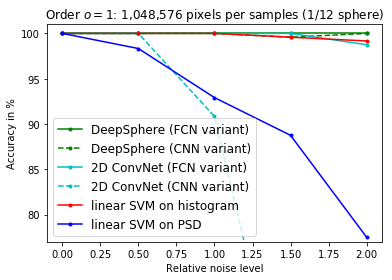

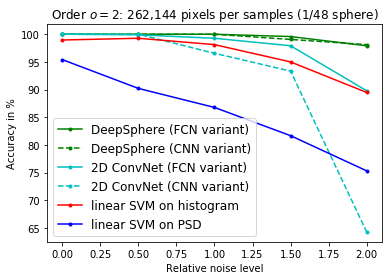

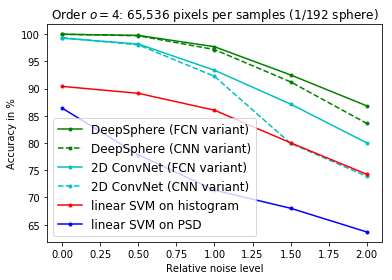

In [17]:
for order in[1, 2, 4]:
    x_hist, y_hist = get_xy(hist_result, order)
    x_deepsphere_fcn, y_deepsphere_fcn = get_xy(deepsphere_result_fcn, order)
    x_deepsphere_cnn, y_deepsphere_cnn = get_xy(deepsphere_result_cnn, order)
    x_psd, y_psd = get_xy(psd_result, order)
    
    x_cnn2d_fcn_reg, y_cnn2d_fcn_reg = get_xy(cnn2d_result_fcn_reg, order)
    x_cnn2d_cnn_reg, y_cnn2d_cnn_reg = get_xy(cnn2d_result_cnn_reg, order)
    x_cnn2d_fcn_big_reg, y_cnn2d_fcn_big_reg = get_xy(cnn2d_result_fcn_big_reg, order)
    x_cnn2d_cnn_big_reg, y_cnn2d_cnn_big_reg = get_xy(cnn2d_result_cnn_big_reg, order)    
    
    acc_hist = (1-y_hist)*100
    acc_deepsphere_fcn = (1-y_deepsphere_fcn)*100
    acc_deepsphere_cnn = (1-y_deepsphere_cnn)*100
    acc_psd = (1-y_psd)*100

    acc_cnn2d_fcn_reg = (1-y_cnn2d_fcn_reg)*100
    acc_cnn2d_cnn_reg = (1-y_cnn2d_cnn_reg)*100
    acc_cnn2d_fcn_big_reg = (1-y_cnn2d_fcn_big_reg)*100
    acc_cnn2d_cnn_big_reg = (1-y_cnn2d_cnn_big_reg)*100

    plt.figure(figsize=[6, 4])
    plt.plot(x_deepsphere_fcn, acc_deepsphere_fcn,'g.-', label='DeepSphere (FCN variant)')
    plt.plot(x_deepsphere_cnn, acc_deepsphere_cnn,'g.--', label='DeepSphere (CNN variant)')
    plt.plot(x_cnn2d_fcn_reg, acc_cnn2d_fcn_reg,'c.-', label='2D ConvNet (FCN variant)')
    plt.plot(x_cnn2d_cnn_reg, acc_cnn2d_cnn_reg,'c.--', label='2D ConvNet (CNN variant)')
#     plt.plot(x_cnn2d_fcn_big_reg, acc_cnn2d_fcn_big_reg,'m.-', label='2DCNN (FCN variant)')
#     plt.plot(x_cnn2d_cnn_big_reg, acc_cnn2d_cnn_big_reg,'m.--', label='2DCNN (CNN variant)')
    plt.plot(x_hist, acc_hist,'r.-', label='linear SVM on histogram')
    plt.plot(x_psd, acc_psd,'b.-', label='linear SVM on PSD')
    plt.legend(loc=3, prop={'size': 12})
    plt.xlabel('Relative noise level')
    plt.ylabel('Accuracy in %')
    npix = (1024//order)**2
    part = 12 * order**2
    plt.title('Order $o={}$: {:,} pixels per samples (1/{} sphere)'.format(order, npix, part))
    if order==1:
        plt.ylim( (77, 101))
    
    plt.savefig(os.path.join(pathfig, "result_order{}.pdf".format(order)), bbox_inches='tight')

In [18]:
# deepsphere_result_params = np.load('results/deepsphere/deepsphere_results_list_sigma{}_params.npz'.format(sigma))['data']

In [19]:
# def make_tab(order, results):
#     print('-'*48)
#     print('| {} | {} |'.format('Network'.ljust(30),'Accuracy % '))
#     print('-'*48)
#     for result in results:
#         if int(result[0])==int(order):
#             print('| {} |    {:0.2f}    |'.format(result[3].ljust(30), 100*(1-float(result[2]))))
#     print('-'*48)

# make_tab(4, deepsphere_result_params)

In [20]:
# make_tab(2, deepsphere_result_params)

## 6 Experimental data: show two convergence maps, one per model

In [21]:
img1 = hp.read_map('data/same_psd/kappa_omega_m_0p31_s_2.fits')
img2 = hp.read_map('data/same_psd/kappa_omega_m_0p26_s_2.fits')
img1 = hp.reorder(img1, r2n=True)
img2 = hp.reorder(img2, r2n=True)
Nside = 1024
img1 = hp.ud_grade(img1, nside_out=Nside, order_in='NESTED')
img2 = hp.ud_grade(img2, nside_out=Nside, order_in='NESTED')
cmin = min(np.min(img1), np.min(img2))
cmax = max(np.max(img1), np.max(img2))
cmax = -2*cmin

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [22]:
# _ = plt.hist(img1,bins=100)

In [23]:
# hp.mollview(img1, title='Map 1, omega_m=0.31, pk_norm=0.82, h=0.7', nest=True, min=cmin, max=cmax)
# hp.mollview(img2, title='Map 2, omega_m=0.26, sigma_8=0.91, h=0.7', nest=True, min=cmin, max=cmax)

In [24]:
def arcmin2rad(x):
    return x / 60 / 360 * 2 * np.pi

def gaussian_smoothing(sig, sigma, nest=True):
    if nest:
        sig = hp.reorder(sig, n2r=True)
    smooth = hp.sphtfunc.smoothing(sig, sigma=arcmin2rad(sigma))
    if nest:
        smooth = hp.reorder(smooth, r2n=True)
    return smooth
sigma=3

/home/defferra/miniconda3/envs/scnn/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


<Figure size 612x388.8 with 0 Axes>

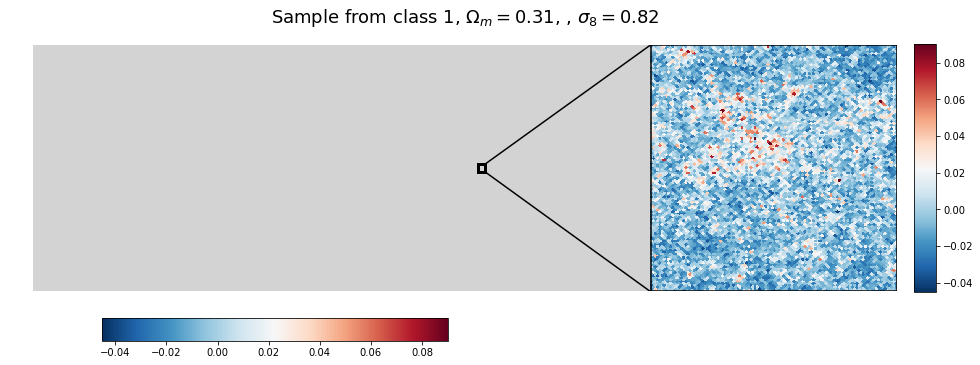

In [25]:
fig = plot.zoom_mollview(img1, cmin=cmin, cmax=cmax)
plt.suptitle('Sample from class 1, $\Omega_m=0.31$, , $\sigma_8=0.82$',y=0.78, fontsize=18);
# omega_m=0.31, pk_norm=0.82, h=0.7

Sigma is 3.000000 arcmin (0.000873 rad) 
-> fwhm is 7.064460 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/defferra/miniconda3/envs/scnn/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


<Figure size 612x388.8 with 0 Axes>

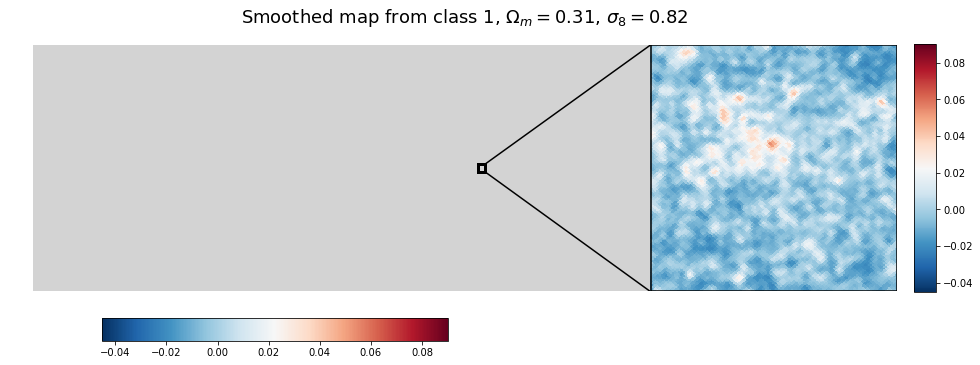

In [26]:
fig = plot.zoom_mollview(gaussian_smoothing(img1,sigma), cmin=cmin, cmax=cmax)
plt.suptitle('Smoothed map from class 1, $\Omega_m=0.31$, $\sigma_8=0.82$',y=0.78, fontsize=18)
plt.savefig(os.path.join(pathfig, "smooth_map_class_1.pdf"), bbox_inches='tight')
# omega_m=0.31, pk_norm=0.82, h=0.7

/home/defferra/miniconda3/envs/scnn/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


<Figure size 612x388.8 with 0 Axes>

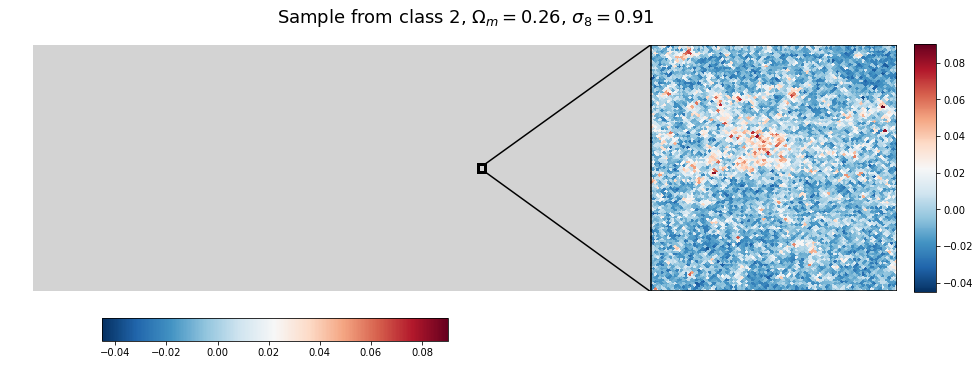

In [27]:
fig = plot.zoom_mollview(img2, cmin=cmin, cmax=cmax)
_ = plt.suptitle('Sample from class 2, $\Omega_m=0.26$, $\sigma_8=0.91$',y=0.78, fontsize=18)
# omega_m=0.26, sigma_8=0.91, h=0.7

Sigma is 3.000000 arcmin (0.000873 rad) 
-> fwhm is 7.064460 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/defferra/miniconda3/envs/scnn/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


<Figure size 612x388.8 with 0 Axes>

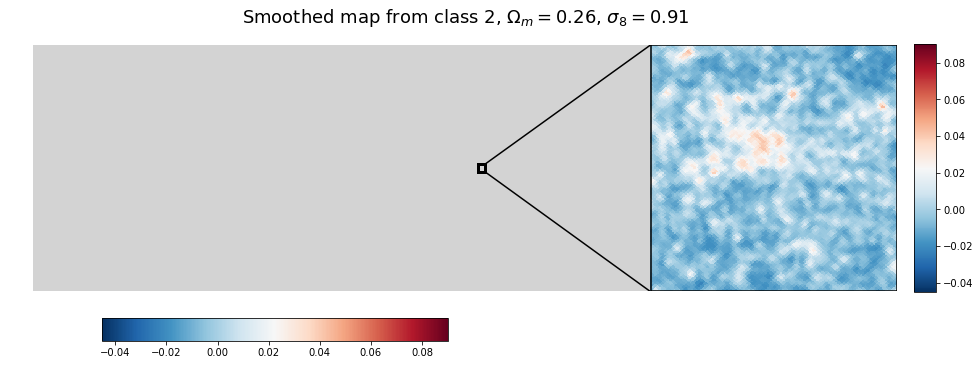

In [28]:
fig = plot.zoom_mollview(gaussian_smoothing(img2, sigma), cmin=cmin, cmax=cmax)
_ = plt.suptitle('Smoothed map from class 2, $\Omega_m=0.26$, $\sigma_8=0.91$',y=0.78, fontsize=18)
plt.savefig(os.path.join(pathfig, "smooth_map_class_2.pdf"), bbox_inches='tight')
# omega_m=0.26, sigma_8=0.91, h=0.7

## 7 Power spectral densities (PSD) of the convergence maps

In [29]:
sigma = 3

In [30]:
compute = False
if compute:
    def psd(x):
        '''Spherical Power Spectral Densities'''
        hatx = hp.map2alm(hp.reorder(x, n2r=True))
        return hp.alm2cl(hatx)
    data_path = 'data/same_psd/'
    ds1 = np.load(data_path+'smoothed_class1_sigma{}.npz'.format(sigma))['arr_0']
    ds2 = np.load(data_path+'smoothed_class2_sigma{}.npz'.format(sigma))['arr_0']
    psds_img1 = [psd(img) for img in ds1]
    psds_img2 = [psd(img) for img in ds2]
    np.savez('results/psd_data_sigma{}'.format(sigma), psd_class1=psds_img1, psd_class2=psds_img2)
else:
    psds_img1 = np.load('results/psd_data_sigma{}.npz'.format(sigma))['psd_class1']
    psds_img2 = np.load('results/psd_data_sigma{}.npz'.format(sigma))['psd_class2']

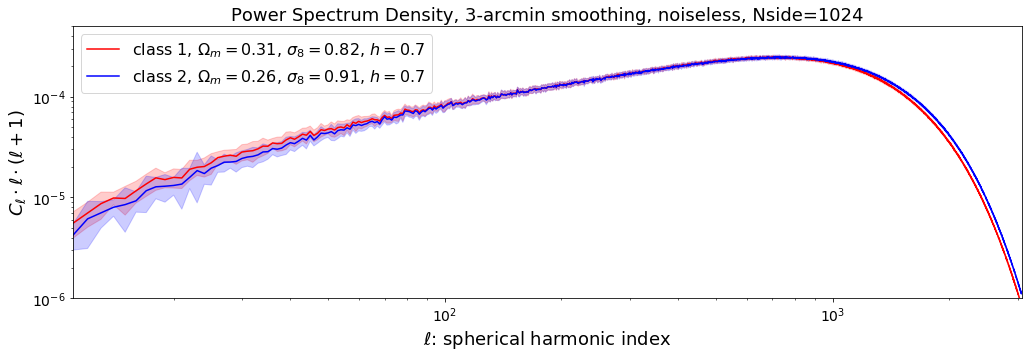

In [31]:
matplotlib.rcParams.update({'font.size': 14})

l = np.array(range(len(psds_img1[0])))

plot.plot_with_std(l,np.stack(psds_img1)*l*(l+1), label='class 1, $\Omega_m=0.31$, $\sigma_8=0.82$, $h=0.7$', color='r')
plot.plot_with_std(l,np.stack(psds_img2)*l*(l+1), label='class 2, $\Omega_m=0.26$, $\sigma_8=0.91$, $h=0.7$', color='b')


plt.legend(fontsize=16);
plt.xlim([11, np.max(l)])
plt.ylim([1e-6, 5e-4])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\ell$: spherical harmonic index', fontsize=18)
plt.ylabel('$C_\ell \cdot \ell \cdot (\ell+1)$', fontsize=18)
plt.title('Power Spectrum Density, 3-arcmin smoothing, noiseless, Nside=1024', fontsize=18);
plt.savefig(os.path.join(pathfig, "psd_sigma{}.pdf".format(sigma)), bbox_inches='tight')
matplotlib.rcParams.update({'font.size': 10})

## 8 Checking convergence of SVM (w.r.t. the number of augmented training samples)

In [32]:
sigma = 3
order = 2
sigma_noise = 1.5

# path = 'results/psd/'
# name = '40sim_1024sides_{0}arcmin_{2:.1f}noise_{1}order.npz'.format(sigma, order, sigma_noise)

path = 'results/histogram/'
name = '40sim_1024sides_{2}noise_{1}order_{0}sigma.npz'.format(sigma, order, sigma_noise)

filepath = os.path.join(path,name)
data = np.load(filepath)['arr_0']

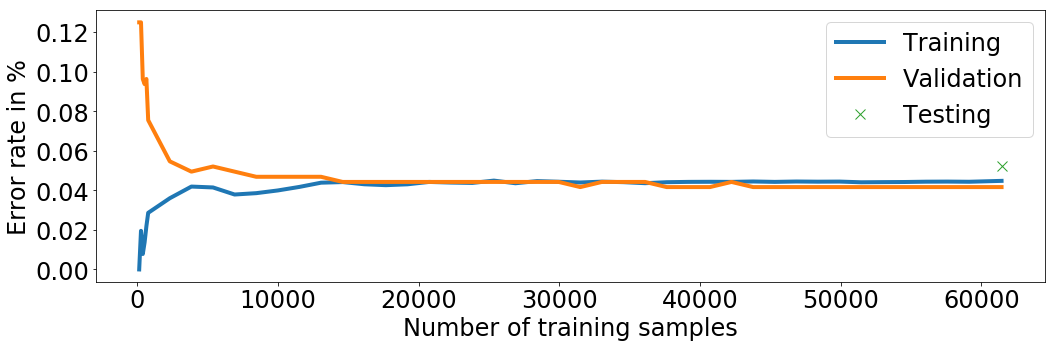

In [33]:
matplotlib.rcParams.update({'font.size': 24})

plt.plot(data[0], data[1], linewidth=4)
plt.plot(data[0], data[2], linewidth=4)
plt.plot(data[0][-1], data[3],'x', markersize=10)
plt.legend(['Training','Validation', 'Testing'])
plt.xlabel('Number of training samples')
plt.ylabel('Error rate in %')
# plt.title('Error for the histogram + SVM, order: {}, noise level: {}'.format(order, sigma_noise))
plt.savefig(os.path.join(pathfig, "hist_error_order{}_noise{}.pdf".format(order, sigma_noise)), bbox_inches='tight')
matplotlib.rcParams.update({'font.size': 10})

## 9 Plotting learned graph convolutional filters

In [34]:
Nside = 1024
order = 2  # 1,2,4,8 correspond to 12,48,192,768 parts of the sphere.
sigma_noise = 2
sigma = 3
ntype = 'FCN'
EXP_NAME = '40sim_{}sides_{:0.1f}noise_{}order_{}sigma_{}'.format(Nside, sigma_noise, order, sigma, ntype)

In [35]:
params = hyperparameters.get_params(12*40*0.8*order*order, EXP_NAME, order, Nside, ntype)

model = models.deepsphere(**params)

#sides: [1024, 512, 256, 128, 64, 32, 32]
#pixels: [262144, 65536, 16384, 4096, 1024, 256, 256]
#samples per batch: 64
=> #pixels per batch (input): 16,777,216
=> #pixels for training (input): 32,212,254,720.0
Learning rate will start at 2.0e-04 and finish at 2.9e-05.
NN architecture
  input: M_0 = 262144
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 262144 * 16 / 4 = 1048576
    weights: F_0 * F_1 * K_1 = 1 * 16 * 5 = 80
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 65536 * 32 / 4 = 524288
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 16384 * 64 / 4 = 262144
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 4096 * 64 / 4 = 65536
    weights: F_3 * F_4 * K_4 = 64 * 64 * 5 = 20480
    biases: F_4 = 64
    batch norm

In [36]:
folder = 'figures/filters/{}/'.format(EXP_NAME)
os.makedirs(folder, exist_ok=True)

In [37]:
layer = 5

/mnt/scratch/lts2/mdeff/deepsphere/deepsphere/../checkpoints/40sim_1024sides_2.0noise_2order_3sigma_FCN
INFO:tensorflow:Restoring parameters from /mnt/scratch/lts2/mdeff/deepsphere/deepsphere/../checkpoints/40sim_1024sides_2.0noise_2order_3sigma_FCN/model-315


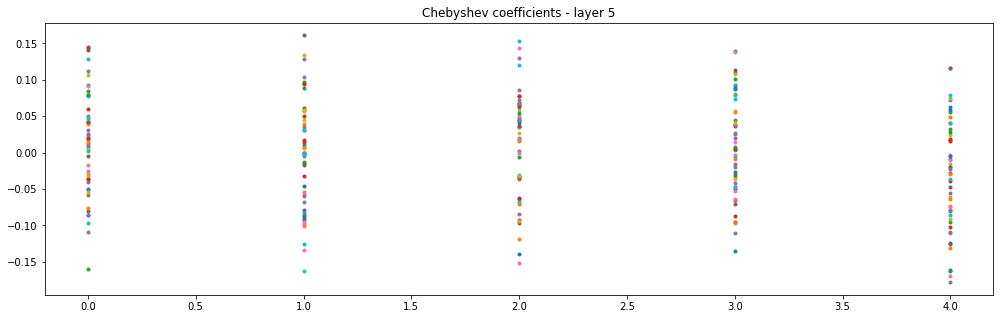

In [38]:
try:
    model.plot_chebyshev_coeffs(layer, ind_in=range(5), ind_out=range(10))
    plt.savefig('{}/layer{}_coefficients.png'.format(folder, layer), dpi=100)
except ValueError:
    raise ValueError('If checkpoints/{} is empty, run the demo_part_sphere notebook first.'.format(EXP_NAME))

/mnt/scratch/lts2/mdeff/deepsphere/deepsphere/../checkpoints/40sim_1024sides_2.0noise_2order_3sigma_FCN
INFO:tensorflow:Restoring parameters from /mnt/scratch/lts2/mdeff/deepsphere/deepsphere/../checkpoints/40sim_1024sides_2.0noise_2order_3sigma_FCN/model-315


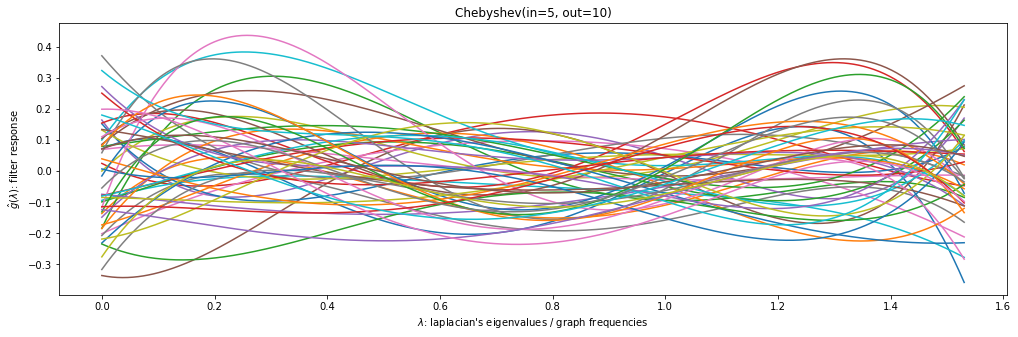

In [39]:
model.plot_filters_spectral(layer, ind_in=range(5), ind_out=range(10));

plt.savefig('{}/layer{}_spectral.png'.format(folder, layer), dpi=100)

/mnt/scratch/lts2/mdeff/deepsphere/deepsphere/../checkpoints/40sim_1024sides_2.0noise_2order_3sigma_FCN
INFO:tensorflow:Restoring parameters from /mnt/scratch/lts2/mdeff/deepsphere/deepsphere/../checkpoints/40sim_1024sides_2.0noise_2order_3sigma_FCN/model-315
4 6


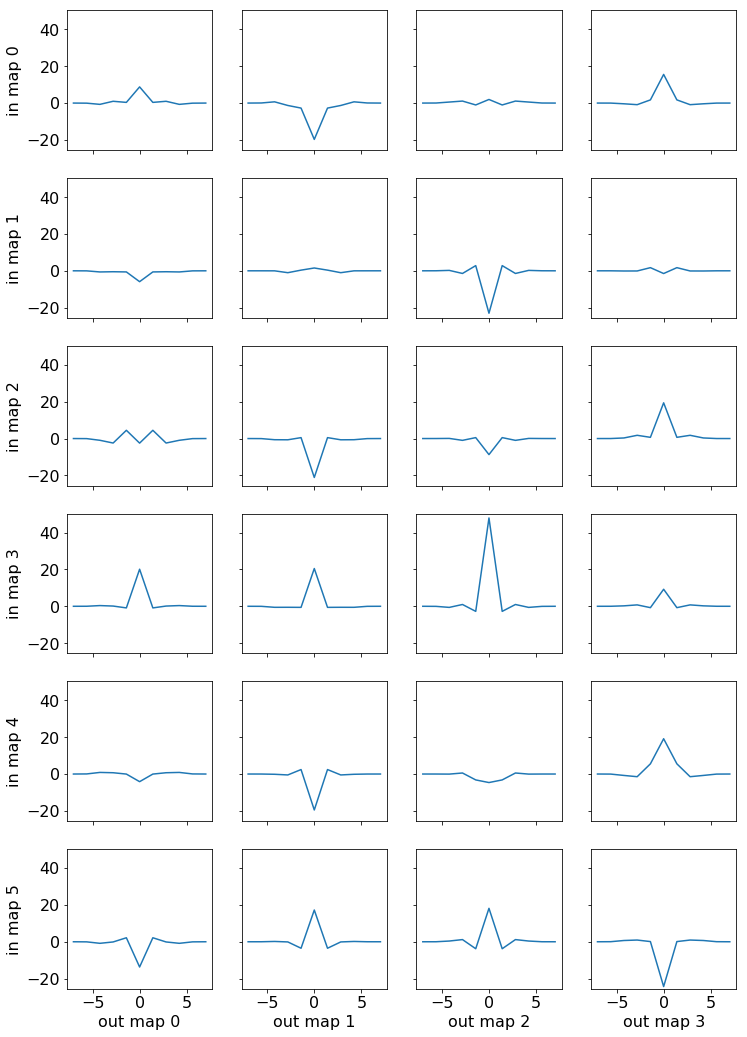

In [40]:
matplotlib.rcParams.update({'font.size': 16})

model.plot_filters_section(layer, ind_in=range(6), ind_out=range(4), title='');
plt.savefig(os.path.join(pathfig, "section_filter_last.pdf".format(order)), bbox_inches='tight')
matplotlib.rcParams.update({'font.size': 10})

/mnt/scratch/lts2/mdeff/deepsphere/deepsphere/../checkpoints/40sim_1024sides_2.0noise_2order_3sigma_FCN
INFO:tensorflow:Restoring parameters from /mnt/scratch/lts2/mdeff/deepsphere/deepsphere/../checkpoints/40sim_1024sides_2.0noise_2order_3sigma_FCN/model-315


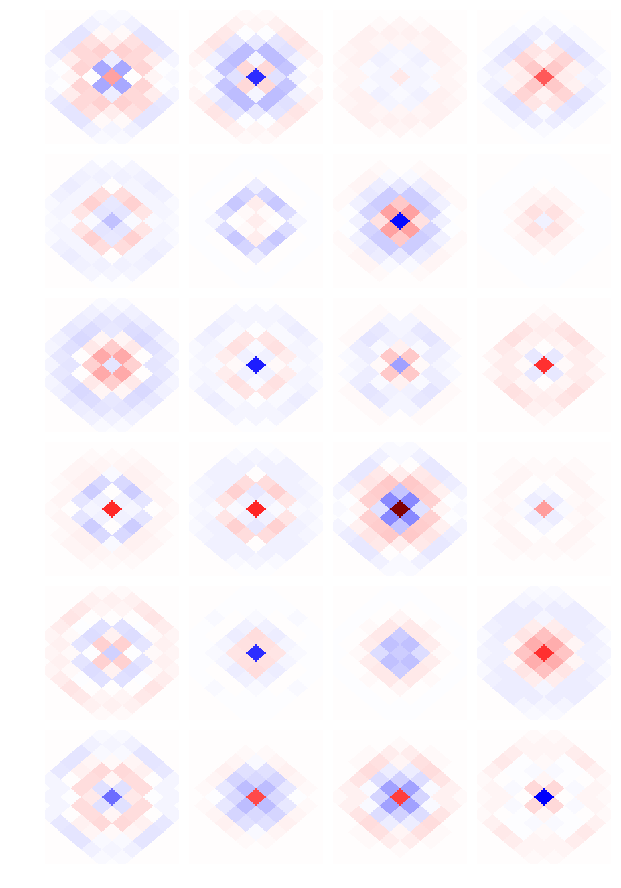

In [41]:
plt.rcParams['figure.figsize'] = (8, 12)
model.plot_filters_gnomonic(layer, ind_in=range(6), ind_out=range(4), title='');
plt.savefig(os.path.join(pathfig, "gnonomic_filter_last.pdf".format(order)), bbox_inches='tight', dpi=100)

/mnt/scratch/lts2/mdeff/deepsphere/deepsphere/../checkpoints/40sim_1024sides_2.0noise_2order_3sigma_FCN
INFO:tensorflow:Restoring parameters from /mnt/scratch/lts2/mdeff/deepsphere/deepsphere/../checkpoints/40sim_1024sides_2.0noise_2order_3sigma_FCN/model-315
4 1


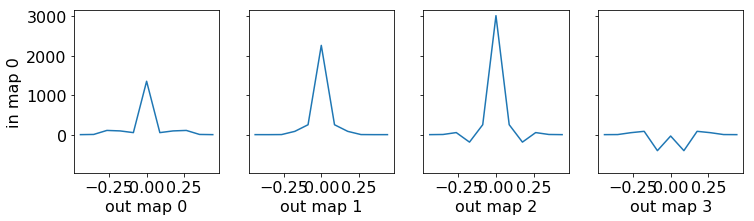

In [42]:
plt.rcParams['figure.figsize'] = (17, 5)  # (9, 4) for matplotlib notebook
matplotlib.rcParams.update({'font.size': 16})

model.plot_filters_section(1, ind_out=range(4), title='');
fig.savefig('{}/layer{}_section.png'.format(folder, layer), dpi=100)
plt.savefig(os.path.join(pathfig, "section_filter_first.pdf".format(order)), bbox_inches='tight')
matplotlib.rcParams.update({'font.size': 10})

## 10 Border effect of the graph convolution (part of the sphere)

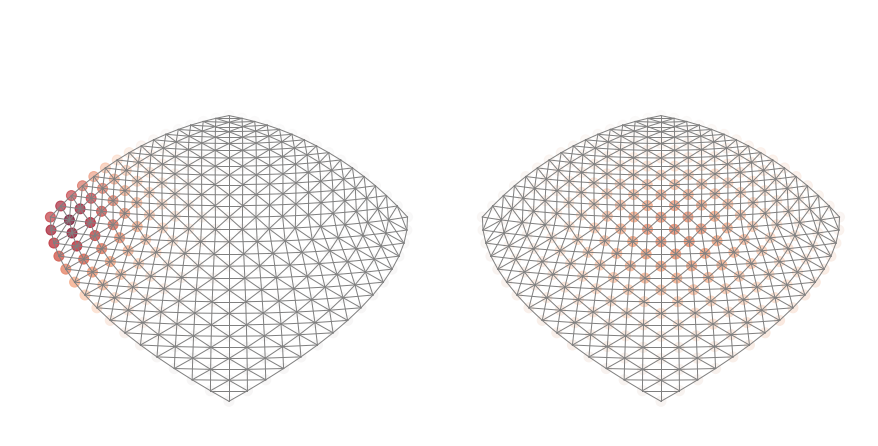

In [43]:
matplotlib.rcParams['image.cmap'] = 'RdBu_r'
nside = 16
indexes = range(nside**2)

G = utils.healpix_graph(nside=nside, indexes=indexes)
G.estimate_lmax()

tau = 30
hf = pygsp.filters.Heat(G, tau=tau)

index1 = 170
index2 = 64+2*16+2*4+2
sig1 = np.zeros([nside**2])
sig2 = np.zeros([nside**2])
sig1[index1] = 1
sig2[index2] = 1

sig1 = hf.filter(sig1)
sig2 = hf.filter(sig2)

m = max(np.max(sig1), np.max(sig2))
limits = [-m, m]

# sig = np.arange(nside**2)
fig = plt.figure(figsize=[12,6])

ax1 = fig.add_subplot(121, projection='3d')

G.plot_signal(sig1, ax=ax1, colorbar=False,limits=limits)

# Get rid of the ticks
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
# Get rid of the panes
ax1.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax1.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax1.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax1.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Zoom
a = 0.35
ax1.set_xlim(-a,a)
ax1.set_ylim(-a,a)

# Remove the title
# ax.set_title('Graph, half sphere, Nside=4')
ax1.set_title('', FontSize=16)

ax1.view_init(elev=10, azim=45)

ax2 = fig.add_subplot(122, projection='3d')

G.plot_signal(sig2, ax=ax2, limits=limits, colorbar=False)

# Get rid of the ticks
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
# Get rid of the panes
ax2.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax2.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax2.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax2.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Zoom
a = 0.35
ax2.set_xlim(-a,a)
ax2.set_ylim(-a,a)

# Remove the title
# ax.set_title('Graph, half sphere, Nside=4')
ax2.set_title('', FontSize=16)

ax2.view_init(elev=10, azim=45)

plt.tight_layout(pad=0)
plt.savefig(os.path.join(pathfig, "border_effects.pdf"), bbox_inches='tight')

In [44]:
# for nside in [16, 32, 64, 128, 256, 512, 1024, 2048]:
#     print('Time for nside: {}'.format(nside))
#     %timeit G = utils.healpix_graph(nside=nside)

## 11 Natural projection of Healpix to the plane

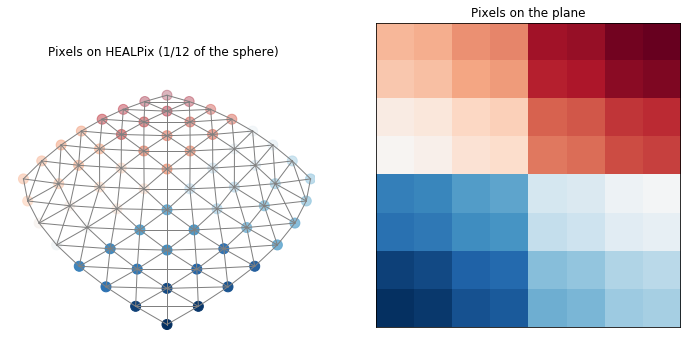

In [45]:
nside = 8
indexes = range(nside**2)
G = utils.healpix_graph(nside=nside, indexes=indexes)
sig1 = np.arange(nside**2)
fig = plt.figure(figsize=[12,6])

ax1 = fig.add_subplot(121, projection='3d')
ax1.axis('off')

G.plot_signal(sig1, ax=ax1, colorbar=False, edges=True)

# Zoom
a = 0.3
ax1.set_xlim(-a, a)
ax1.set_ylim(-a, a)

ax1.view_init(elev=10, azim=45)
ax1.set_title('Pixels on HEALPix (1/12 of the sphere)')

ax2 = fig.add_subplot(122)
ind = experimental.cnn.build_index(3).flatten().astype(np.int)
ax2.imshow(np.flipud(sig1[ind].reshape([nside, nside])))
ax2.set_title('Pixels on the plane')
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

fig.savefig(os.path.join(pathfig, 'projection_healpix_plane.pdf'))

## 12 Filtering speed

Numbers measured in the `spherical_vs_graph` notebook.

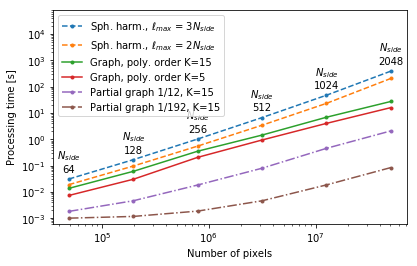

In [46]:
results = np.load('results/filtering_speed.npz')

fig, ax = plt.subplots(figsize=(5.9, 3.8))
npix = [hp.nside2npix(nside) for nside in results['nsides']]

ax.loglog(npix, results['times_sphere'][:, ::-1], '--', marker='.')
ax.loglog(npix, results['times_graph'][:, ::-1], '-', marker='.')
ax.loglog(npix, results['times_part'][:, 1, 0], '-.', marker='.')
ax.loglog(npix, results['times_part'][:, 1, 2], '-.', marker='.')

#ax.loglog(npix, np.array(npix)/1e6, ':', color='#808080')
#ax.loglog(npix, (np.array(npix)/1e6)**1.5, ':', color='#808080')

labels = ['Sph. harm., $\ell_{{max}}$ = {}$N_{{side}}$'.format(lm) for lm in results['lmax'][::-1]]
labels += ['Graph, poly. order K={}'.format(order) for order in results['orders'][::-1]]
labels += ['Partial graph 1/{}, K={}'.format(v, 15) for v in [12, 192]]

#labels += [r'Asymptotic $\mathcal{O}(N_{side})$']
#labels += [r'Asymptotic $\mathcal{O}(N_{side}^{3/2})$']
ax.legend(labels, loc='upper left')
for i, nside in enumerate(results['nsides']):
    x = npix[i]
    y = results['times_sphere'][i, -1] * 2
    ax.text(x, y, '$N_{{side}}$\n{}'.format(nside), horizontalalignment='center')

ax.set_ylim(0.6 * results['times_part'][:,1,:].min(), 8e4)#6e2 * results['times_sphere'].max())
#ax.set_xlim(0.5 * min(npix), 2 * max(npix))
ax.set_xlabel('Number of pixels')
ax.set_ylabel('Processing time [s]')

fig.tight_layout()
fig.savefig(os.path.join(pathfig, 'filtering_speed.pdf'))

## 13 Eigenvalues of graph Laplacian are grouped (like the degree of the spherical harmonics)

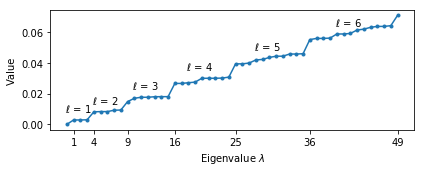

In [47]:
n_eigenvalues = 50
nside = 16

graph = utils.healpix_graph(nside=nside, lap_type='normalized', nest=True, dtype=np.float64)
graph.compute_fourier_basis(n_eigenvectors=n_eigenvalues)

fig, ax = plt.subplots(figsize=(6, 2.5))
ax.plot(graph.e, '.-')
idx = 1
xticks = [idx]
for l in range(1, 7):
    ax.text(idx + l - 2.3, graph.e[idx + l] + 0.005, '$\ell$ = {}'.format(l))
    idx += 2*l + 1
    xticks.append(idx)
ax.set_xlabel('Eigenvalue $\lambda$')
ax.set_ylabel('Value')
ax.set_xticks(xticks)
fig.tight_layout()
fig.savefig(os.path.join(pathfig, 'graph_eigenvalues.pdf'))

## 14 Correspondance of subspaces

### 14.1 Graph eigenvectors vs sampled spherical harmonics

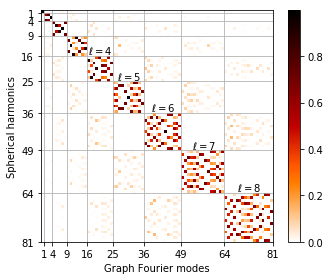

In [48]:
nside = 16
lmax = 8

def compute_orhtogonality(nside, lmax, lap_type='normalized'):
    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))

    harmonics = utils.compute_spherical_harmonics(nside, lmax=lmax)

    graph = utils.healpix_graph(nside, lap_type=lap_type, nest=True, dtype=np.float64)
    n_eigenvectors = min(n_harmonics[-1], graph.N)
    graph.compute_fourier_basis(n_eigenvectors)

    C = harmonics.T @ graph.U
    
    return C, n_harmonics

C, n_harmonics = compute_orhtogonality(nside, lmax)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(np.abs(C), cmap=plt.cm.gist_heat_r, aspect='equal')
ax.set_xlabel('Graph Fourier modes')
ax.set_ylabel('Spherical harmonics')
ax.set_xticks(n_harmonics - 0.5)
ax.set_yticks(n_harmonics - 0.5)
ax.set_xticklabels(n_harmonics)
ax.set_yticklabels(n_harmonics)
for l in range(4, lmax+1):
    ax.text(n_harmonics[l-1] + l - 3.9, n_harmonics[l-1] - 1, '$\ell={}$'.format(l))
ax.grid(True)
fig.colorbar(im)
fig.tight_layout()
fig.savefig(os.path.join(pathfig, 'subspace_harmonics_eigenvectors.pdf'));

### 14.2 SHT of the graph eigenvectors

In [49]:
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64)
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

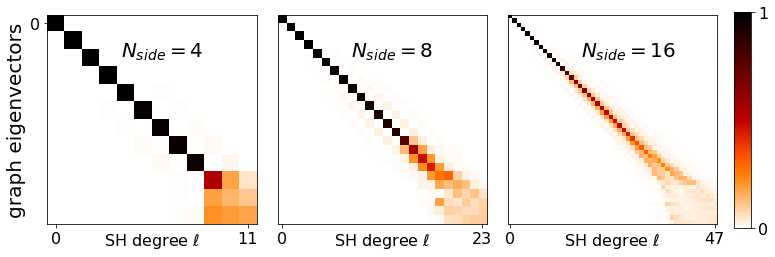

In [50]:
fontsize = matplotlib.rcParams['font.size']
matplotlib.rcParams['font.size'] = 16 

#fig, axes = plt.subplots(1, len(nsides), figsize=(6, 3))
matplotlib.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, len(nsides), figsize=(12, 6))

for ax, (nside, sc) in zip(axes.flatten(), spectral_content.items()):
    lmax = 3*nside-1
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    #ax.set_title(rf'$N_{{side}}={nside}$')
    ax.text(0.35, 0.8, rf'$N_{{side}}={nside}$', fontsize=20, transform=ax.transAxes)
    #ax.set_xlabel('SH degree $\ell$')
    ax.text(0.5, -0.1, 'SH degree $\ell$', horizontalalignment='center', transform=ax.transAxes)
    #ax.yaxis.set_visible(False)
    #ax.set_yticklabels([])
    ax.set_yticks([])
    #ax.set_yticks([0, lmax])
    ax.set_xticks([0, lmax])

axes[0].set_yticks([0])
#axes[0].set_ylabel('subspaces of graph eigenvectors')
axes[0].set_ylabel('graph eigenvectors', fontsize=20)

fig.subplots_adjust(wspace=0.1, right=0.9)
ax_cbar = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(im, ax=ax, cax=ax_cbar, ticks=[0, 1])

#fig.tight_layout()  # Doesn't work with color bar.
fig.savefig(os.path.join(pathfig, 'subspace_harmonics_eigenvectors_v2.pdf'));

matplotlib.rcParams['font.size'] = fontsize;

## 15 Convolution basis: Chebyshev polynomials vs monomials

1. Orthogonality of the basis in the spectral domain.
1. Orthogonality of the basis in the vertex domain.
1. Expected shape of the filters given a distribution over the coefficients.

Todo:
* compute the expectation analytically

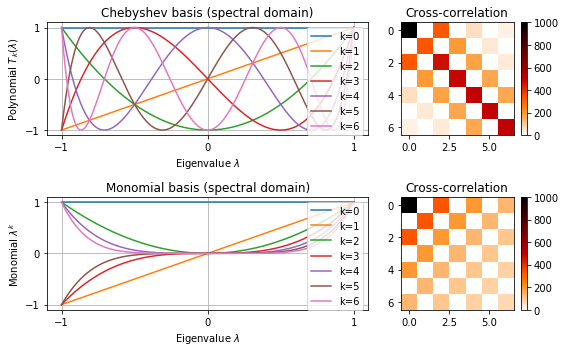

In [51]:
matplotlib.rcParams.update({'font.size': 10})

# Order of Chebyshev polynomials. Degree of monomials
degree = 7

n_points = 1000

graph = pygsp.graphs.Path(64)

# Irregular graph. Otherwise the Chebyshev polynomials are exactly orthogonal.
graph.W.data = 0.5 + 0.1 * np.random.uniform(size=graph.W.data.shape)
graph = pygsp.graphs.Graph(pygsp.utils.symmetrize(graph.W))
#plt.imshow(graph.W.toarray())

graph.estimate_lmax()
graph.set_coordinates('line1D')

fig = plt.figure(figsize=(8, 5))

# Chebyshev

#x = np.linspace(0, 1.05*graph.lmax, 1000)
x = np.linspace(0, graph.lmax, n_points)

coefficients = np.identity(degree)
f = pygsp.filters.Chebyshev(graph, coefficients)
Y = f.evaluate(x)

ax = plt.subplot2grid((2, 3), (0, 0), colspan=2)
ax.plot(x / graph.lmax * 2 - 1, Y.T)
ax.legend(['k={}'.format(k) for k in range(degree)])
ax.set_xlabel('Eigenvalue $\lambda$')
ax.set_ylabel('Polynomial $T_k(\lambda)$')
ax.set_title('Chebyshev basis (spectral domain)')
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.grid()

C = Y @ Y.T

ax = plt.subplot2grid((2, 3), (0, 2))
im = ax.imshow(np.abs(C), cmap=plt.cm.gist_heat_r)
fig.colorbar(im, ax=ax)
ax.set_title('Cross-correlation')

# Monomials

x = np.linspace(-1, 1, n_points)

Y = np.empty((degree, len(x)))
for k in range(degree):
    Y[k] = x**k

ax = plt.subplot2grid((2, 3), (1, 0), colspan=2)
plt.plot(x, Y.T)
ax.legend(['k={}'.format(k) for k in range(degree)])
ax.set_xlabel('Eigenvalue $\lambda$')
ax.set_ylabel('Monomial $\lambda^k$')
ax.set_title('Monomial basis (spectral domain)')
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.grid()

C = Y @ Y.T

ax = plt.subplot2grid((2, 3), (1, 2))
im = ax.imshow(np.abs(C), cmap=plt.cm.gist_heat_r)
fig.colorbar(im, ax=ax)
ax.set_title('Cross-correlation')

fig.tight_layout()
fig.savefig(os.path.join(pathfig, 'polynomial_bases_spectrum.pdf'))

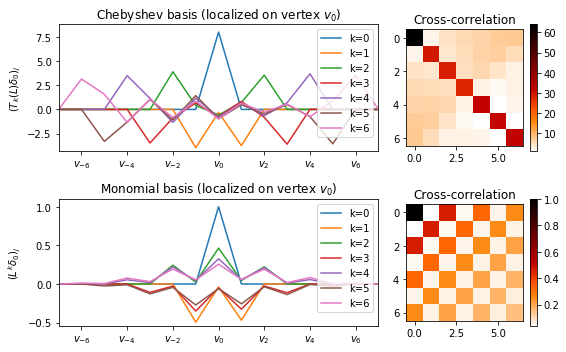

In [52]:
fig = plt.figure(figsize=(8, 5))

# Chebyshev

Y = f.localize(graph.N // 2)

ax = plt.subplot2grid((2, 3), (0, 0), colspan=2, fig=fig)
for k in range(degree):
    graph.plot_signal(Y[k], ax=ax)
ax.legend(['k={}'.format(k) for k in range(degree)])
ax.set_ylim(1.1*Y.min(), 1.1*Y.max())
ax.set_xlim(graph.N // 2 - degree, graph.N // 2 + degree)
ax.set_xticks(np.arange(graph.N // 2 - degree + 1, graph.N // 2 + degree, 2))
ax.set_xticklabels('$v_{{{}}}$'.format(i) for i in range(- degree + 1, degree, 2))
ax.set_title('Chebyshev basis (localized on vertex $v_0$)')
ax.set_ylabel('($T_k(L) \delta_0)_j$')

C = Y @ Y.T

ax = plt.subplot2grid((2, 3), (0, 2), fig=fig)
im = ax.imshow(np.abs(C), cmap=plt.cm.gist_heat_r)
fig.colorbar(im, ax=ax)
ax.set_title('Cross-correlation')

# Monomials

Y = np.empty((degree, graph.N))
s = np.zeros(graph.N)
s[graph.N // 2] = 1
L = graph.L / graph.lmax * 2 - sparse.identity(graph.N)
for k in range(degree):
    Y[k] = L**k @ s

ax = plt.subplot2grid((2, 3), (1, 0), colspan=2, fig=fig)
for k in range(degree):
    graph.plot_signal(Y[k], ax=ax)
ax.legend(['k={}'.format(k) for k in range(degree)])
ax.set_ylim(1.1*Y.min(), 1.1*Y.max())
ax.set_xlim(graph.N // 2 - degree, graph.N // 2 + degree)
ax.set_xticks(np.arange(graph.N // 2 - degree + 1, graph.N // 2 + degree, 2))
ax.set_xticklabels('$v_{{{}}}$'.format(i) for i in range(- degree + 1, degree, 2))
ax.set_title('Monomial basis (localized on vertex $v_0$)')
ax.set_ylabel('($L^k \delta_0)_j$')

C = Y @ Y.T

ax = plt.subplot2grid((2, 3), (1, 2), fig=fig)
im = ax.imshow(np.abs(C), cmap=plt.cm.gist_heat_r)
fig.colorbar(im, ax=ax)
ax.set_title('Cross-correlation')

fig.tight_layout()
fig.savefig(os.path.join(pathfig, 'polynomial_bases_vertex.pdf'))

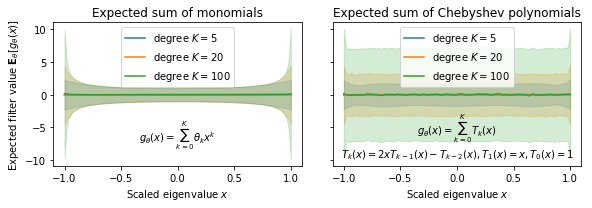

In [53]:
degrees = [5, 20, 100]
n_realizations = int(1e4)
n_points = 100

x = np.linspace(-1, 1, n_points)

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8.5, 3))

for degree in degrees:
    coefficients = np.random.normal(0, 1, size=(degree, n_realizations))
    #coefficients = np.random.uniform(-1, 1, size=(order, n_realizations))

    # Monomials.
    y = np.zeros((n_realizations, n_points))
    for k, c in enumerate(coefficients):
        y += np.outer(c, x**k)
    plot.plot_with_std(x, y, ax=axes[0])

    # Chebyshev polynomials.
    graph = pygsp.graphs.Path(n_points)
    graph.estimate_lmax()
    filters = pygsp.filters.Chebyshev(graph, coefficients)
    y = filters.evaluate((x + 1) / 2 * graph.lmax)
    plot.plot_with_std(x, y, ax=axes[1])

legend = ['degree $K={}$'.format(degree) for degree in degrees]
axes[0].legend(legend, loc='upper center')
axes[1].legend(legend, loc='upper center')
axes[0].set_xlabel('Scaled eigenvalue $x$')
axes[1].set_xlabel('Scaled eigenvalue $x$')
axes[0].set_ylabel(r'Expected filter value $\mathbf{E}_\theta[ g_\theta(x) ]$')
axes[0].set_title('Expected sum of monomials')
axes[1].set_title('Expected sum of Chebyshev polynomials')
axes[0].text(0, -7, r'$g_\theta(x) = \sum_{k=0}^K \theta_k x^k$', horizontalalignment='center')
axes[1].text(0, -6, r'$g_\theta(x) = \sum_{k=0}^K T_k(x)$', horizontalalignment='center')
axes[1].text(0, -9.5, r'$T_k(x) = 2xT_{k-1}(x) - T_{k-2}(x), T_1(x) = x, T_0(x) = 1$', horizontalalignment='center')
fig.tight_layout()
fig.savefig(os.path.join(pathfig, 'expected_filters.pdf'))

In [54]:
# x = np.arange(-1,1,0.001)

# order = 20
# c = np.random.randn(order,100)
# f = []
# for coeffs in c.T:
#     s = 0*x
#     for o, coeff in enumerate(coeffs):
#         s += coeff*(x**o)
#     f.append(s)
# f = np.array(f)
# ax = plot.plot_with_std(x, f)
# ax.set_title('Monomial - order {}'.format(order));

In [55]:
# x = np.arange(-1,1,0.001)

# order = 20
# c = np.random.randn(order,100)
# f = []
# p = []
# p.append(x**0)
# p.append(x**1)
# for o in range(2, order):
#     p.append(2*x*p[o-1]-p[o-2])
# for coeffs in c.T:
#     s = x**0
#     for o, coeff in enumerate(coeffs):
#         s += coeff*p[o]
#     f.append(s)
# f = np.array(f)
# ax = plot.plot_with_std(x, f)
# ax.set_title('Chebyshev - order {}'.format(order));

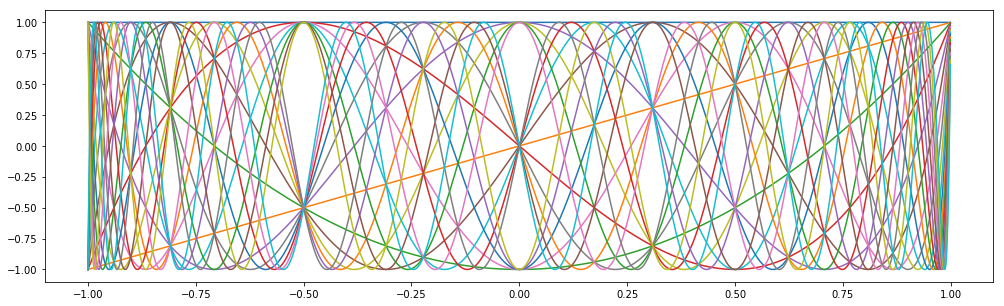

In [56]:
x = np.arange(-1,1,0.001)
order =20
p = []
p.append(x**0)
p.append(x**1)
for o in range(2,order):
    p.append(2*x*p[o-1]-p[o-2])

for o in range(order):
    plt.plot(x, p[o])

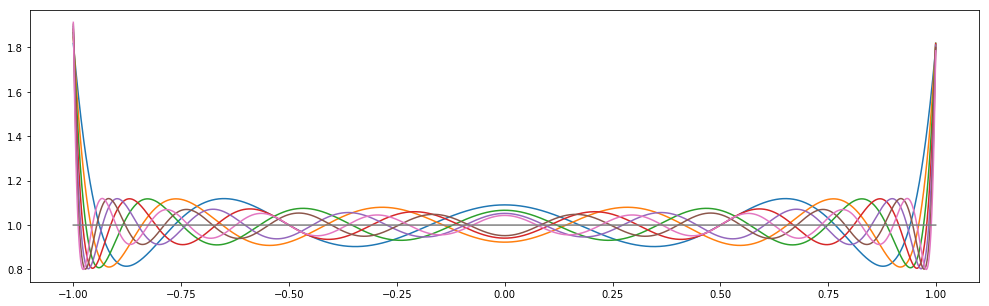

In [57]:
for o in range(5,12):
    plt.plot(x, np.sum(np.array(p[0:o])**2/(o+0.5)*2,axis=0))
plt.plot(x, x**0)

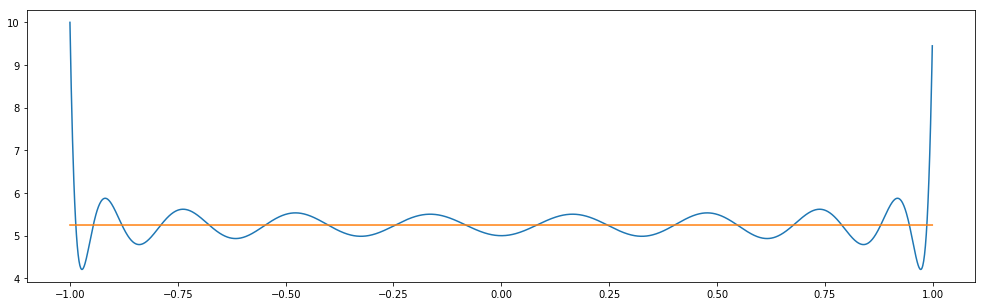

In [58]:
o = 10
plt.plot(x, np.sum(np.array(p[0:o])**2,axis=0))
plt.plot(x, (o+0.5)/2*(x**0))